In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shutil
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

In [ ]:
# Cutting into slices
#Notice that only need to run this once for cutting slices
import os
import re
from pydub import AudioSegment

# Create the slice folder if it doesn't exist
output_folder = "test_slices"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Extract the number from the filename
def get_file_number(filename):
    match = re.match(r"(\d+)\.wav", filename)
    return int(match.group(1)) if match else None

# Rename files to ensure they are ordered numerically
def rename_files_in_order(folder):
    files = os.listdir(folder)
    slice_files = [f for f in files if re.match(r"\d+\.wav", f)]
    slice_files.sort(key=lambda x: get_file_number(x))  # Sort by number

    # Rename files to order them sequentially
    for i, filename in enumerate(slice_files):
        expected_filename = f"x{i}.wav"
        current_path = os.path.join(folder, filename)
        expected_path = os.path.join(folder, expected_filename)
        if filename != expected_filename:
            os.rename(current_path, expected_path)

# Ensure the files are named in order
rename_files_in_order(output_folder)

# Get the current highest number
existing_files = os.listdir(output_folder)
slice_files = [f for f in existing_files if re.match(r"\d+\.wav", f)]
if slice_files:
    slice_files.sort(key=lambda x: get_file_number(x))  # Sort by number
    start_index = get_file_number(slice_files[-1]) + 1  # Start from the next number after the highest one
else:
    start_index = 0  # If no files exist, start from 0

# Load the wav file
audio = AudioSegment.from_wav("4.wav")

# Slice length in milliseconds
slice_length = 3000

# Slice and save the segments
for i in range(0, len(audio), slice_length):
    segment = audio[i:i + slice_length]
    # Export to the slice folder, naming from start_index onwards
    segment.export(os.path.join(output_folder, f"{start_index}.wav"), format="wav")
    start_index += 1


In [2]:

base_dir = '/Users/zhuxinyuan/tensorflow-test/mine/Erhu-Pizzicato/test_slices'
folder_0 = os.path.join(base_dir, '0')
folder_1 = os.path.join(base_dir, '1')
folder_test = os.path.join(base_dir, 'test')
combined_folder = os.path.join(base_dir, 'combined')

def extract_number(filename):
    return int(filename.replace('slice_', '').split('.')[0])
    
if os.path.exists(combined_folder):
    shutil.rmtree(combined_folder)  # Delete repeated folders
os.makedirs(combined_folder)  

# sort files in folder "0"
files_0 = sorted([f for f in os.listdir(folder_0) if f != '.DS_Store'], key=lambda x: int(os.path.splitext(x)[0]))


new_num = 0
for index,file_name in enumerate(files_0):
    old_file_path = os.path.join(folder_0, file_name)
    new_file_name = f"{new_num}.wav"  
    new_file_path = os.path.join(folder_0, new_file_name)
    os.rename(old_file_path, new_file_path)
    shutil.copy(new_file_path, combined_folder) # move to "combined"
    new_num += 1


# get maximum in folder 0
max_index = len(files_0)

# rename files in folder 1
files_1 = sorted([f for f in os.listdir(folder_1) if f != '.DS_Store'], key=lambda x: int(os.path.splitext(x)[0]))

one_list = []
new_num2 = max_index
for index,file_name in enumerate(files_1):
    old_file_path = os.path.join(folder_1, file_name)
    new_file_name = f"{new_num2}.wav"  
    new_file_path = os.path.join(folder_1, new_file_name)
    os.rename(old_file_path, new_file_path)
    shutil.copy(new_file_path, combined_folder)
    one_list.append(max_index + index)  # record new orderings
    new_num2+= 1

print(max_index)
print(len(files_1))

293
84


In [4]:
# random seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data.astype(type(data[0]))

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(len(data) * shift_max))
    return np.roll(data, shift)

def change_pitch(data, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

def stretch_audio(data, stretch_factor=0.8):
    return librosa.effects.time_stretch(data, rate=stretch_factor)


# Mel spectrum
# a frequency representation commonly used for audio classification
def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=None)
    if augment:
        y = add_noise(y)
        y = time_shift(y)
        y = change_pitch(y, sr)
        y = stretch_audio(y)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=256)

    # Delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)
    

    # Combine Mel Spectrogram and MFCC features
    combined_features = np.vstack((mel_spec_db, mfcc, delta_mfcc))

    # Normalize the combined features
    combined_features_norm = (combined_features - np.mean(combined_features)) / np.std(combined_features)

    # Padding or Trimming
    if combined_features_norm.shape[1] < 431:
        combined_features_norm = np.pad(combined_features_norm, ((0, 0), (0, 431 - combined_features_norm.shape[1])), mode='constant', constant_values=(0, 0))
    elif combined_features_norm.shape[1] > 431:
        combined_features_norm = combined_features_norm[:, :431]

    return combined_features_norm




def plot_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)  # load audio files
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # turn to db

    plt.figure(figsize=(10, 4))  # set image size
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')  # show image
    plt.colorbar(format='%+2.0f dB') 
    plt.title('Mel-Spectrogram')  
    plt.tight_layout() 
    plt.show()
    
# prepare dataset for Mel
def prepare_dataset(file_paths, labels, augment=False):
    features = []
    valid_labels = []
    
    for file, label in zip(file_paths, labels):
        feature = extract_features(file, augment=augment)
       
        features.append(feature)
        valid_labels.append(label)
    
    # adjust reshape paras
    features = np.array(features)  
    return features, np.array(valid_labels)
   
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(154, 431, 1)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),  # Increased dropout ratio
        
        Conv2D(64, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Flatten(),
        
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Increased L2 regularization
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

file_paths = [f'/Users/zhuxinyuan/tensorflow-test/mine/Erhu-Pizzicato/test_slices/combined/{i}.wav' for i in range(max_index + len(files_1))]

labels = [0] * (max_index + len(files_1))
for i in one_list:
    labels[i] = 1
print(labels)

X, y = prepare_dataset(file_paths, labels)  # data augmentation
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = build_model()

# possible weight change
class_weight_dict = {0: 1.0, 1: 1.0}


# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

# evaluation
model.evaluate(X_test, y_test)

model.save('erhutest.h5')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

2025-01-30 10:50:26.727942: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-30 10:50:26.727981: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-30 10:50:26.727997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-30 10:50:26.728053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-30 10:50:26.728083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-01-30 10:50:27.403081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 7.4603 - accuracy: 0.6608

2025-01-30 10:50:33.817002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 7s 609ms/step - loss: 7.4603 - accuracy: 0.6608 - val_loss: 3.1798 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - 4s 354ms/step - loss: 2.7706 - accuracy: 0.8761 - val_loss: 3.4571 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - 4s 337ms/step - loss: 2.4858 - accuracy: 0.9705 - val_loss: 4.0095 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 4/100
11/11 [==============================] - 4s 349ms/step - loss: 2.3474 - accuracy: 0.9941 - val_loss: 5.2355 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 5/100
11/11 [==============================] - 4s 414ms/step - loss: 2.2583 - accuracy: 0.9882 - val_loss: 6.1694 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 6/100
11/11 [==============================] - ETA: 0s - loss: 2.1526 - accuracy: 0.9941
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
11/11 [==============================] - 

/Users/zhuxinyuan/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 154, 431, 32)      320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 154, 431, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 154, 431, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 77, 215, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 77, 215, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 215, 64)       1

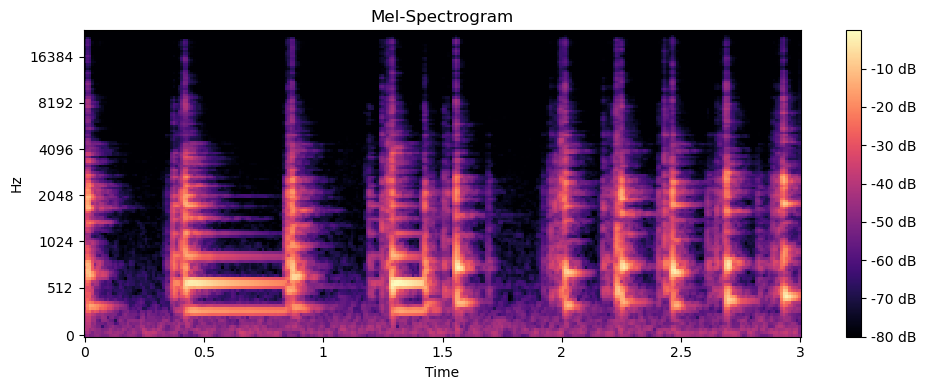

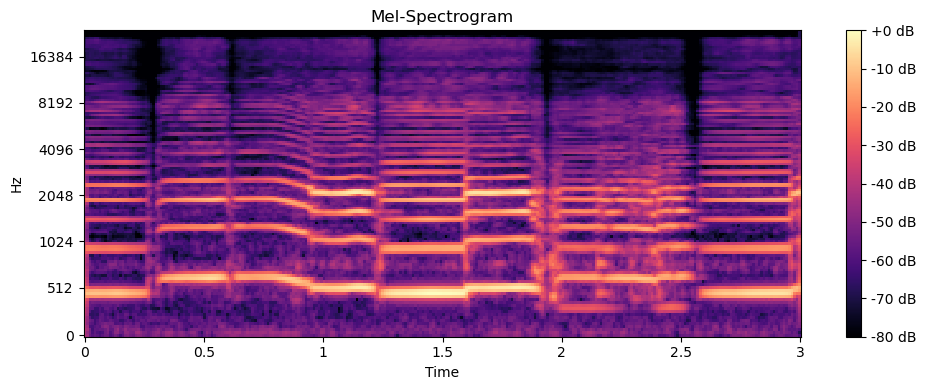

In [9]:
plot_mel_spectrogram('/Users/zhuxinyuan/tensorflow-test/mine/Erhu-Pizzicato/test_slices/1/301.wav')
plot_mel_spectrogram('/Users/zhuxinyuan/tensorflow-test/mine/Erhu-Pizzicato/test_slices/0/23.wav')

1/1 [==============================] - 0s 12ms/step


2025-01-30 10:52:35.220329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


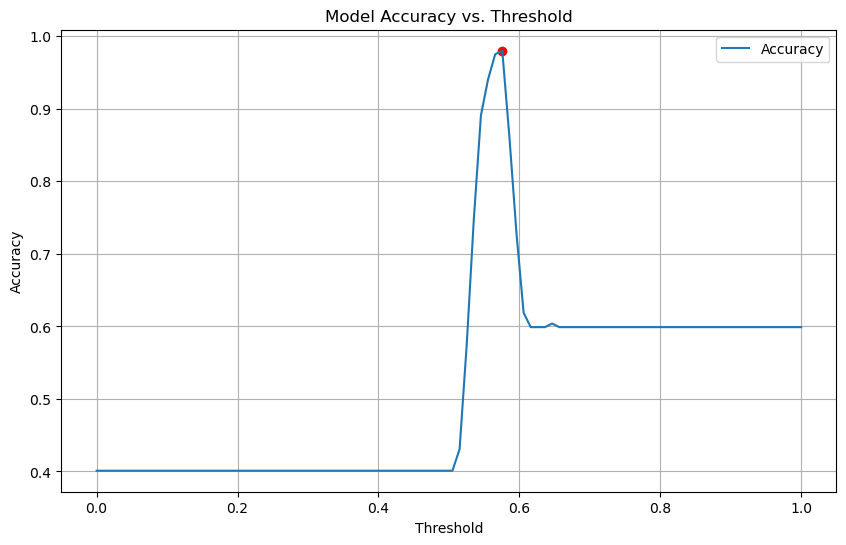

Best Threshold: 0.5758
Best Accuracy: 98.0198%


In [10]:

# Load the pre-trained model
model = load_model('erhutest.h5')

def predict_pizzicato(file_path, model, threshold=0.5):
    feature = extract_features(file_path)  # Extract features with correct dimensions

    # Ensure feature shape is correct
    if feature.shape != (154, 431):
        feature = np.pad(feature, [(0, 154 - feature.shape[0]), (0, 431 - feature.shape[1])], mode='constant', constant_values=0)
    
    # Reshape for model input
    feature = feature.reshape(1, 154, 431, 1)
    prediction = model.predict(feature)
    return prediction[0][0]

def evaluate_model(test_folder, model):
    test_file_paths = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if file.endswith('.wav')]
    answers, predicted_probs = [], []

    for file_path in test_file_paths:
        file_name = os.path.basename(file_path)
        label = 0 if file_name.startswith('x') else 1
        answers.append(label)
        prob = predict_pizzicato(file_path, model)
        predicted_probs.append(prob)

    thresholds = np.linspace(0, 1, 100)
    accuracies = []

    for threshold in thresholds:
        predictions = [1 if p >= threshold else 0 for p in predicted_probs]
        accuracy = accuracy_score(answers, predictions)
        accuracies.append(accuracy)

    best_threshold = thresholds[np.argmax(accuracies)]
    best_accuracy = np.max(accuracies)

    # Plotting the accuracy vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.scatter([best_threshold], [best_accuracy], color='red')  # Highlight the best threshold
    plt.title('Model Accuracy vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_accuracy

# Usage
test_folder = '/Users/zhuxinyuan/tensorflow-test/mine/Erhu-Pizzicato/test_slices/test'
best_threshold, best_accuracy = evaluate_model(test_folder, model)
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Accuracy: {best_accuracy:.4%}")
